In [1]:
import os
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas_datareader as web
from dateutil.relativedelta import relativedelta
import h5py
from dotenv import load_dotenv
import yaml
from ticker_download_predict_upload import DownloadPredictUpload
from s3_uploader import S3Uploader

In [2]:
dpu = DownloadPredictUpload()

### Set the tickers in the portfolio

In [3]:
tickers = ["I:SPX", "QQQ", "VXUS", "GLD"]
D = len(tickers)

### Get the past year of ticker close prices

In [4]:
long_df_filename = os.path.join("input", f"Year of Tickers {dpu.get_today_date()}.csv")
if os.path.exists(long_df_filename):
    long_df = pd.read_csv(long_df_filename)
    long_df["datetime"] = pd.to_datetime(long_df["datetime"])
    long_df["datetime"] = long_df["datetime"].apply(
        lambda x: pd.Timestamp(x).replace(hour=23, minute=59, second=59)
    )
    long_df.set_index("datetime", inplace=True)
    long_df.sort_index(inplace=True)
else:
    date_from = dpu.past_business_day(pd.Timestamp(dpu.get_today_date()), 253)
    date_to = dpu.past_business_day(pd.Timestamp(dpu.get_today_date()), 1).replace(
        hour=23, minute=59, second=59
    )
    print(date_from, date_to)
    long_df = dpu.get_tickers(tickers, date_from=date_from, date_to=date_to)
    long_df.to_csv(long_df_filename, index=True)
long_df

2024-05-21 00:00:00 2025-05-23 23:59:59
I:SPX. Acquired 254 so far. Sleeping 5 seconds...
QQQ. Acquired 508 so far. Sleeping 5 seconds...
VXUS. Acquired 762 so far. Sleeping 5 seconds...
GLD. Acquired 1016 so far. Sleeping 5 seconds...


,ticker,open,high,low,close,volume,vwap,transactions
datetime,,,,,,,,
2024-05-20 23:59:59,I:SPX,5305.35,5325.320,5302.400,5308.13,NaN,NaN,NaN
2024-05-20 23:59:59,QQQ,451.98,455.580,451.785,454.91,24368626.0,454.3206,239818.0
2024-05-20 23:59:59,GLD,223.79,225.660,223.020,224.56,5990860.0,224.4813,62476.0
2024-05-20 23:59:59,VXUS,62.17,62.349,62.130,62.21,2961720.0,62.2461,12558.0
2024-05-21 23:59:59,GLD,224.77,225.210,223.700,224.23,4002615.0,224.3565,51107.0
...,...,...,...,...,...,...,...,...
2025-05-22 23:59:59,I:SPX,5841.26,5878.080,5825.820,5842.01,NaN,NaN,NaN
2025-05-23 23:59:59,QQQ,506.18,511.840,505.580,509.24,58368075.0,509.0460,697090.0
2025-05-23 23:59:59,I:SPX,5781.89,5829.510,5767.410,5802.82,NaN,NaN,NaN


### Pivot the close prices for better analysis

In [5]:
wide_df = dpu.pivot_ticker_close_wide(long_df)
date_from = wide_df.index[0]
date_to = wide_df.index[-1]
wide_df

ticker,GLD,I:SPX,QQQ,VXUS
2024-05-20 17:00:00,224.56,5308.13,454.91,62.21
2024-05-21 17:00:00,224.23,5321.41,455.80,62.03
2024-05-22 17:00:00,220.11,5307.01,455.71,61.56
2024-05-23 17:00:00,215.72,5267.84,453.66,61.15
2024-05-24 17:00:00,215.92,5304.72,457.95,61.64
...,...,...,...,...
2025-05-19 17:00:00,298.03,5963.60,522.01,66.74
2025-05-20 17:00:00,303.58,5940.46,520.27,66.95
2025-05-21 17:00:00,305.82,5844.61,513.04,66.64
2025-05-22 17:00:00,303.11,5842.01,514.00,66.53


### Are there any missing values?

In [6]:
wide_df.isna().sum().sum()

np.int64(0)

### Calculate % change and covert to a percentage

In [7]:
returns_df = wide_df.pct_change()
returns_df = returns_df.iloc[1:] * 100
returns_df

ticker,GLD,I:SPX,QQQ,VXUS
2024-05-21 17:00:00,-0.146954,0.250182,0.195643,-0.289343
2024-05-22 17:00:00,-1.837399,-0.270605,-0.019746,-0.757698
2024-05-23 17:00:00,-1.994457,-0.738080,-0.449847,-0.666017
2024-05-24 17:00:00,0.092713,0.700097,0.945642,0.801308
2024-05-28 17:00:00,1.051315,0.024883,0.377770,-0.032446
...,...,...,...,...
2025-05-19 17:00:00,1.288064,0.087608,0.095875,0.678835
2025-05-20 17:00:00,1.862229,-0.388021,-0.333327,0.314654
2025-05-21 17:00:00,0.737862,-1.613511,-1.389663,-0.463032
2025-05-22 17:00:00,-0.886142,-0.044485,0.187120,-0.165066


### Calculate mean returns

In [8]:
mean_returns = returns_df.mean()
mean_returns

ticker
GLD      0.133592
I:SPX    0.042790
QQQ      0.057237
VXUS     0.033570
dtype: float64

### Calculate covariance matrix

In [9]:
cov = returns_df.cov()
cov_np = cov.to_numpy()
cov

ticker,GLD,I:SPX,QQQ,VXUS
ticker,,,,
GLD,1.282559,0.166285,0.225153,0.491469
I:SPX,0.166285,1.528740,1.915131,1.007384
QQQ,0.225153,1.915131,2.560532,1.244438
VXUS,0.491469,1.007384,1.244438,1.151669


### Simulate 10,000 portfolios by generating random weights

Softmax is used to generate random vector of positive floats summing to 1.0. Not used if short selling is allowed in the simulations.

In [10]:
def softmax_random_distribution(D):
    """
    Generates a NumPy array of D random floats that sum to 1.0 using the softmax function.

    The process involves:
    1. Generating D random numbers (from a standard normal distribution).
    2. Applying the softmax function to these numbers. Softmax converts a vector
        of numbers into a probability distribution where each element is non-negative
        and all elements sum to 1.0.

    Parameters
    ----------
    D : int 
        The desired number of elements (dimension) in the output array.
        Must be a positive integer.

    Returns
    -------
    np.ndarray
        A NumPy array of shape (D,) containing floats that sum to 1.0.

    Raises
    ------
    ValueError: If D is not a positive integer.
    """
    if not isinstance(D, int) or D <= 0:
        raise ValueError("Dimension D must be a positive integer.")
    random_inputs = np.random.randn(D)
    stable_inputs = random_inputs - np.max(random_inputs)
    exponentials = np.exp(stable_inputs)
    softmax_output = exponentials / np.sum(exponentials)
    return softmax_output

In [11]:
n_portfolios = 10_000
simulated_returns = np.zeros(n_portfolios)
simulated_risks = np.zeros(n_portfolios)
random_weights = []
rand_range = 1.0

for i in range(n_portfolios):
    w = np.random.random(D) * rand_range - rand_range / 2  # Allows short selling
    w[-1] = 1 - w[:-1].sum()
    np.random.shuffle(w)
    # w = softmax_random_distribution(D)  # No short selling
    random_weights.append(w)
    simulated_return = mean_returns.dot(w)
    simulated_risk = np.sqrt(w.dot(cov_np).dot(w))
    simulated_returns[i] = simulated_return
    simulated_risks[i] = simulated_risk

### Calculate minimum variance portfolio

In [12]:
weight_bounds = [(-0.5, None)] * D  # Allows shorting
# weight_bounds = [(0.0, 1.0) for _ in range(D)]  # No shorting

In [13]:
def get_portfolio_variance(weights):
    return weights.dot(cov_np).dot(weights)

In [14]:
def portfolio_weights_constraint(weights):
    return weights.sum() - 1

In [15]:
min_var_result = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
min_var_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.623726589574902
       x: [ 4.495e-01  9.513e-01 -5.000e-01  9.916e-02]
     nit: 6
     jac: [ 1.342e+00  1.343e+00  1.533e+00  1.343e+00]
    nfev: 31
    njev: 6

In [16]:
min_var_risk = np.sqrt(min_var_result.fun)
min_var_weights = min_var_result.x
min_var_return = min_var_weights.dot(mean_returns)
min_var_risk, min_var_weights, min_var_return

(np.float64(0.7897636289263402),
 array([ 0.44949443,  0.95134347, -0.5       ,  0.0991621 ]),
 np.float64(0.07546748834617942))

### Calculate efficient frontier

In [17]:
num_portfolios = 100
max_simulated_return = max(simulated_returns)
print(f"Possible returns range: {min_var_return:.4f} to {max_simulated_return:.4f}")
target_returns = np.linspace(min_var_return, max_simulated_return, num_portfolios)
target_returns

Possible returns range: 0.0755 to 0.2589


array([0.07546749, 0.07732048, 0.07917347, 0.08102646, 0.08287946,
       0.08473245, 0.08658544, 0.08843843, 0.09029142, 0.09214441,
       0.09399741, 0.0958504 , 0.09770339, 0.09955638, 0.10140937,
       0.10326236, 0.10511536, 0.10696835, 0.10882134, 0.11067433,
       0.11252732, 0.11438031, 0.11623331, 0.1180863 , 0.11993929,
       0.12179228, 0.12364527, 0.12549826, 0.12735126, 0.12920425,
       0.13105724, 0.13291023, 0.13476322, 0.13661621, 0.13846921,
       0.1403222 , 0.14217519, 0.14402818, 0.14588117, 0.14773416,
       0.14958716, 0.15144015, 0.15329314, 0.15514613, 0.15699912,
       0.15885212, 0.16070511, 0.1625581 , 0.16441109, 0.16626408,
       0.16811707, 0.16997007, 0.17182306, 0.17367605, 0.17552904,
       0.17738203, 0.17923502, 0.18108802, 0.18294101, 0.184794  ,
       0.18664699, 0.18849998, 0.19035297, 0.19220597, 0.19405896,
       0.19591195, 0.19776494, 0.19961793, 0.20147092, 0.20332392,
       0.20517691, 0.2070299 , 0.20888289, 0.21073588, 0.21258

In [18]:
def target_returns_constraint(weights, target_return):
    return weights.dot(mean_returns) - target_return

In [19]:
constraints = [
    {"type": "eq", "fun": target_returns_constraint, "args": [target_returns[0]]},
    {"type": "eq", "fun": portfolio_weights_constraint},
]

In [20]:
print("Weight bounds", weight_bounds)

optimized_risks = []
for target_return in target_returns:
    constraints[0]["args"] = [target_return]
    result = minimize(
        fun=get_portfolio_variance,
        x0=np.ones(D) / D,
        method="SLSQP",
        bounds=weight_bounds,
        constraints=constraints,
    )
    if result.status == 0:
        optimized_risks.append(np.sqrt(result.fun))
    else:
        optimized_risks.append(np.nan)
        print(f"Infeasible target return: {target_return:.4f}")

Weight bounds [(-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None)]


### Calculate Sharpe Ratio

In [21]:
today_date = dpu.get_today_date()
risk_free_rate_filename = os.path.join("input", f"Risk Free Rate {today_date}.json")
if os.path.exists(risk_free_rate_filename):
    print("Reading risk-free rate cache...")
    with open(risk_free_rate_filename, "r", encoding="utf-8") as f:
        risk_free_rate_data = json.load(f)
        print(risk_free_rate_data)
        daily_risk_free_rate = risk_free_rate_data["daily_risk_free_rate"]
else:
    end_date = datetime.datetime.now()
    start_date = end_date - relativedelta(years=1)
    print(start_date, end_date)
    tb3m_df = web.DataReader("DTB3", "fred", start_date, end_date).sort_values(
        "DATE", ascending=False
    )
    risk_free_rate = float(tb3m_df.iloc[0]["DTB3"])
    daily_risk_free_rate = risk_free_rate / 252
    risk_free_rate_date = str(tb3m_df.index[0])
    print(daily_risk_free_rate)
    risk_free_rate_data = {
        "risk_free_rate": risk_free_rate,
        "daily_risk_free_rate": daily_risk_free_rate,
        "risk_free_rate_date": risk_free_rate_date,
    }
    with open(risk_free_rate_filename, "w", encoding="utf-8") as f:
        json.dump(risk_free_rate_data, f, indent=4)

2024-05-27 11:24:54.605686 2025-05-27 11:24:54.605686
0.016865079365079364


In [22]:
def negative_sharpe_ratio(weights):
    mean = weights.dot(mean_returns)
    risk = np.sqrt(weights.dot(cov_np).dot(weights))
    return -(mean - daily_risk_free_rate) / risk

In [23]:
sharpe_ratio_result = minimize(
    fun=negative_sharpe_ratio,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
sharpe_ratio_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.11527450682295003
       x: [ 1.130e+00  1.361e-01  2.337e-01 -5.000e-01]
     nit: 10
     jac: [-7.692e-03 -8.189e-03 -7.940e-03  5.152e-03]
    nfev: 50
    njev: 10

In [24]:
best_sharpe_ratio = -sharpe_ratio_result.fun
best_weights = sharpe_ratio_result.x
opt_risk = np.sqrt(best_weights.dot(cov_np).dot(best_weights))
opt_return = best_weights.dot(mean_returns)
best_sharpe_ratio, best_weights

(np.float64(0.11527450682295003),
 array([ 1.13012015,  0.13613877,  0.23374108, -0.5       ]))

In [25]:
best_weights_pct = pd.Series(best_weights * 100, index=mean_returns.index)
best_weights_pct

ticker
GLD      113.012015
I:SPX     13.613877
QQQ       23.374108
VXUS     -50.000000
dtype: float64

In [26]:
best_weights_pct_dict = best_weights_pct.to_dict()
best_weights_pct_dict

{'GLD': 113.01201492288561,
 'I:SPX': 13.613877130692256,
 'QQQ': 23.374107946422114,
 'VXUS': -50.0}

### Calculate tangency line

In [27]:
tangency_max_risk = max(optimized_risks)
tangency_xs = np.linspace(0, tangency_max_risk, 100)
tangency_ys = daily_risk_free_rate + best_sharpe_ratio * tangency_xs

### FINALLY! Put it all on a plot

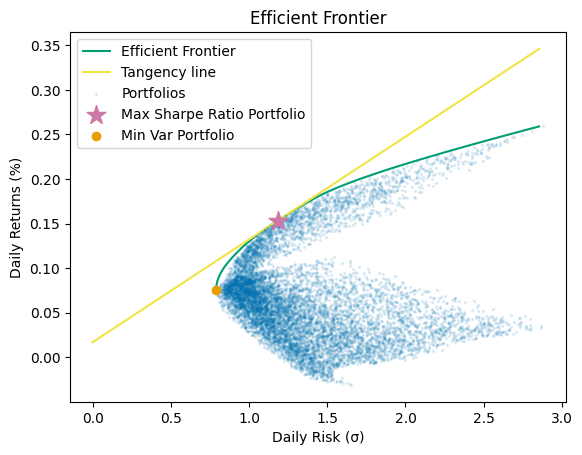

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(
    optimized_risks, target_returns, c="#009E73", zorder=1, label="Efficient Frontier"
)
ax.plot(tangency_xs, tangency_ys, c="#F0E442", zorder=1, label="Tangency line")
ax.scatter(
    simulated_risks,
    simulated_returns,
    alpha=0.1,
    s=2,
    c="#0072B2",
    zorder=10,
    label="Portfolios",
)
ax.scatter(
    [opt_risk],
    [opt_return],
    c="#CC79A7",
    marker="*",
    s=200,
    zorder=10,
    label="Max Sharpe Ratio Portfolio",
)
ax.scatter(
    [min_var_risk], [min_var_return], c="#E69F00", zorder=10, label="Min Var Portfolio"
)
ax.set_xlabel("Daily Risk (σ)")
ax.set_ylabel("Daily Returns (%)")
ax.set_title("Efficient Frontier")
ax.legend()

### Annualize optimum return.

In [29]:
annualized_optimum_return = ((1 + opt_return / 100) ** 252 - 1) * 100
annualized_optimum_risk = opt_risk * np.sqrt(252)
print(annualized_optimum_return, annualized_optimum_risk)

47.14616304074508 18.801436329990477


### Write an HDF5 file with everything needed to regenerate plot

In [30]:
portfolio_optimization_plot_data_filename = os.path.join(
    "output", "portfolio_optimization_plot_data.h5"
)
with h5py.File(portfolio_optimization_plot_data_filename, "w") as hf:
    efficient_frontier_group = hf.create_group("efficient_frontier")
    tangency_line_group = hf.create_group("tangency_line")
    simulated_portfolios_group = hf.create_group("simulated_portfolios")
    max_sharpe_ratio_group = hf.create_group("max_sharpe_ratio")
    min_var_portfolio_group = hf.create_group("min_var_portfolio")
    efficient_frontier_group.create_dataset("xs", data=optimized_risks)
    efficient_frontier_group.create_dataset("ys", data=target_returns)
    tangency_line_group.create_dataset("xs", data=tangency_xs)
    tangency_line_group.create_dataset("ys", data=tangency_ys)
    simulated_portfolios_group.create_dataset("xs", data=simulated_risks)
    simulated_portfolios_group.create_dataset("ys", data=simulated_returns)
    max_sharpe_ratio_group.create_dataset("xs", data=[opt_risk])
    max_sharpe_ratio_group.create_dataset("ys", data=[opt_return])
    min_var_portfolio_group.create_dataset("xs", data=[min_var_risk])
    min_var_portfolio_group.create_dataset("ys", data=[min_var_return])
print(f"Saved {portfolio_optimization_plot_data_filename}")

Saved output/portfolio_optimization_plot_data.h5


In [31]:
load_dotenv()
s3u = S3Uploader()

space_name = os.getenv("PORTFOLIO_OPTIMIZATION_SPACE_NAME")
s3u.upload_file(
    portfolio_optimization_plot_data_filename,
    space_name,
    "portfolio_optimization_plot_data.h5",
)

Upload of portfolio-optimization/portfolio_optimization_plot_data.h5 successful!


### Upload metadata about the plot for the front end UI

In [32]:
metadata = {
    "date_updated": {
        "date_from": str(date_from.date()),
        "date_to": str(date_to.date()),
    },
    "tickers": tickers,
    "risk_free_rate": risk_free_rate_data,
    "optimum_portfolio": {
        "annualized_return": float(annualized_optimum_return),
        "risk": float(annualized_optimum_risk),
        "weights": best_weights_pct_dict
    }
}

metadata_filename = os.path.join("output", "optimization_metadata.yml")
with open(metadata_filename, "w") as f:
    yaml.dump(metadata, f, default_flow_style=False)

s3u.upload_file(
    metadata_filename,
    space_name,
    "optimization_metadata.yml",
)

Upload of portfolio-optimization/optimization_metadata.yml successful!
